## Assignment Week 9: Image Classification Experiments

In this notebook, we're going to explore the use of a few different ways of setting up an image classification model. The images labels are available: http://cs231n.stanford.edu/tiny-imagenet-200.zip. The training set contains 500 images for each of 200 different classes. The validation set contains 50 images for each of the 200 classes. **You must download and unzip this file, putting the resulting directory in the same directory as your assignment notebook.**

Each of the images is a 64x64 pixel image (4096) pixels, each with a rgb value, resulting in 12288 values describing each image.

First, we're going to load images from the tiny-imagenet-200 folder into a *flattened* format that is suitable for training any of the scikit-learn classifier models, such as a tree or logistic regression.

Later, we'll take advantage of data loading functions included in PyTorch that will preserve the 2D-shape of images and load *batches* instead of the entire training or validation set all at once.

**This assignment has one, open-ended question where you are asked to investigate a change to a neural network architecture and see what happens. The code provided will show you how to load in the image data, train neural networks, and evaluate them.**


### Packages

You will need to install the `pytorch` and `torchvision` packages.
To do so, I suggest starting a terminal by choosing File -> New -> Terminal from the JupyterLab menu, and running
`conda install torchvision -c pytorch`

## Helper and Data Loading Functions

In [1]:
%matplotlib inline
%run Helpers.py

In [2]:
def load_train_dataset():
    data_path = './tiny-imagenet-200/train/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    return train_loader, train_dataset.class_to_idx

In [3]:
def load_valid_dataset(class_to_idx):
    data_path = './tiny-imagenet-200/val/images'
    label_file = open('./tiny-imagenet-200/val/val_annotations.txt', 'r')
    label_df = pd.read_csv(label_file, delim_whitespace=True, header=None)
    label_df[1] = label_df[1].apply(lambda x : class_to_idx[x])
    valid_data = []
    for row in label_df.iterrows():
        image = Image.open(f'{data_path}/{row[1][0]}')
        image = torchvision.transforms.functional.to_tensor(image)
        label = row[1][1]
        valid_data.append((image, label))
    return valid_data

In [4]:
def load_data_np(batches=100):
    # Load a subsample of training data and all of the validation data into a flattened NumPy format.
    train_data_np = []
    train_labels = []
    batch_limit = batches
    for index, (data, label) in enumerate(train_dataset):
        for i in range(data.shape[0]):
            train_data_np.append(data[i].detach().numpy().flatten())
            train_labels.append(int(label[i].detach().numpy()))
        if index >= batch_limit - 1:
            break
    train_data_np = np.vstack(train_data_np)
    train_labels = np.array(train_labels)

    valid_data_np = []
    valid_labels = []
    for data, label in valid_dataset:
        if data.shape[0] < 3:
            data = torch.cat([data[0], data[0], data[0]], dim=0)  # Convert grayscale images into RGB format
        valid_data_np.append(data.detach().numpy().flatten())
        valid_labels.append(int(label))
    valid_data_np = np.vstack(valid_data_np)
    valid_labels = np.array(valid_labels)
    return train_data_np, train_labels, valid_data_np, valid_labels

In [5]:
train_dataset, class_to_idx = load_train_dataset()
valid_dataset = load_valid_dataset(class_to_idx)

## Visualize Images and Labels

<ipython-input-6-0ece1489eecd>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


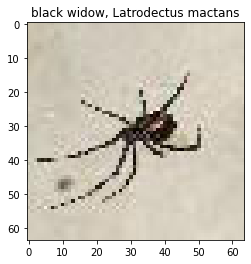

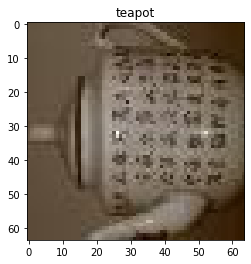

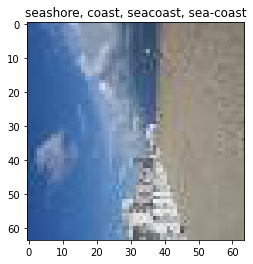

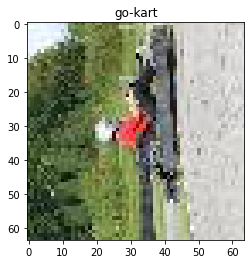

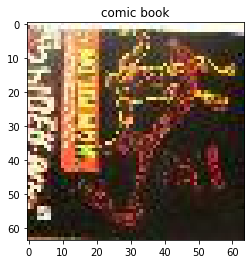

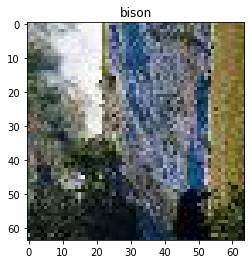

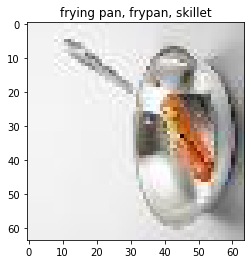

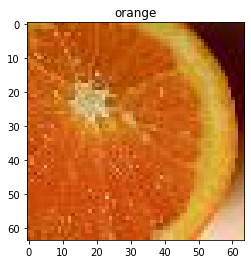

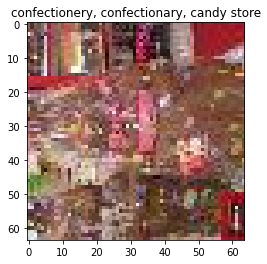

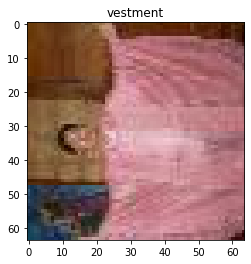

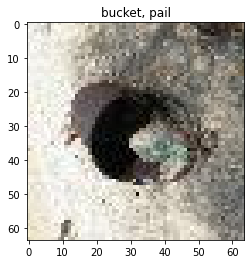

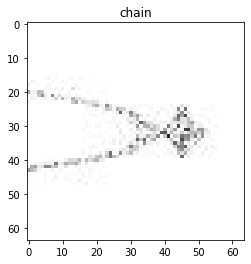

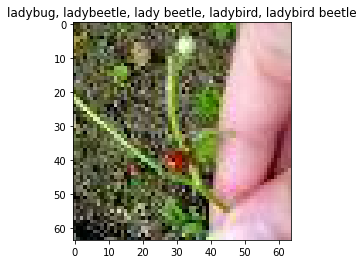

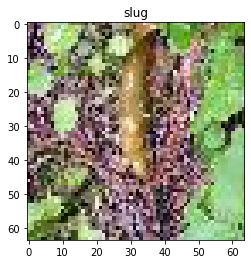

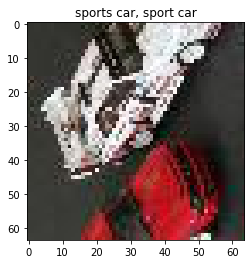

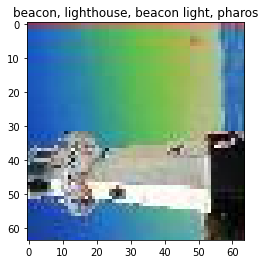

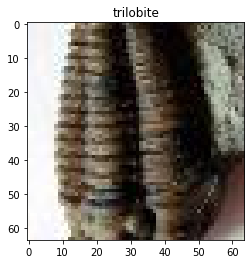

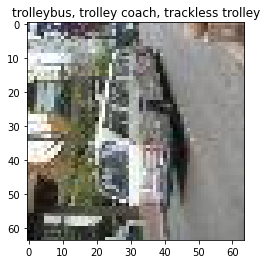

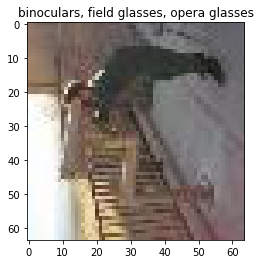

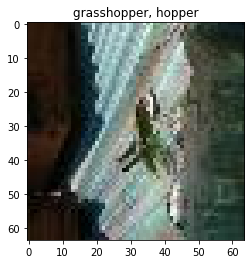

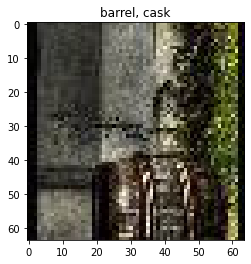

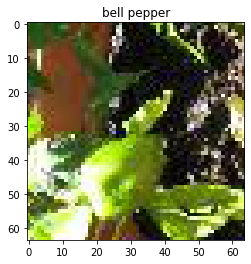

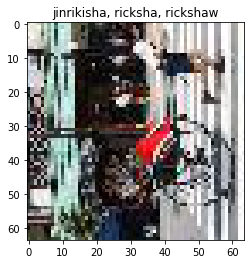

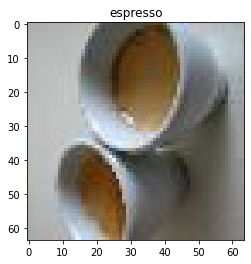

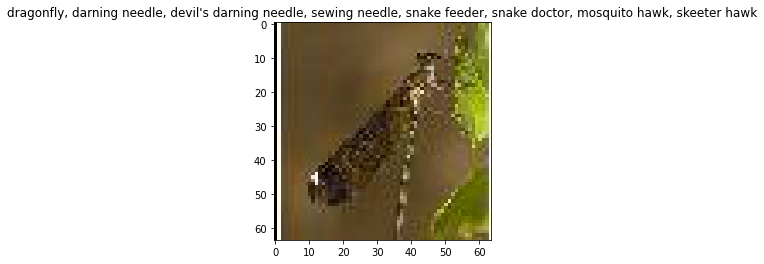

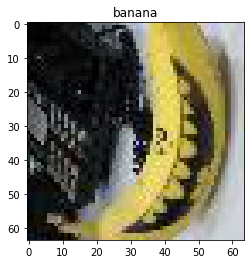

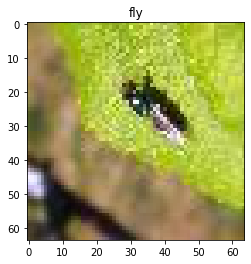

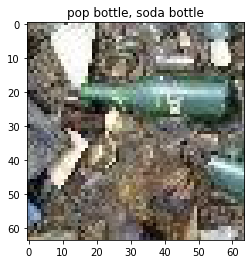

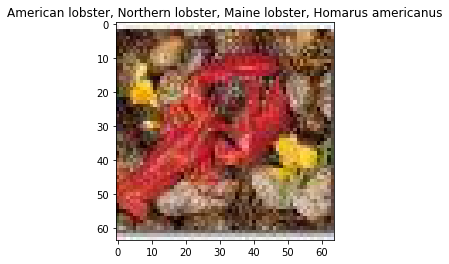

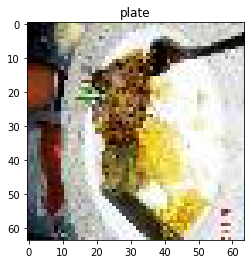

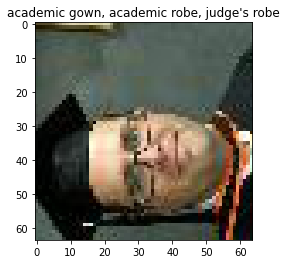

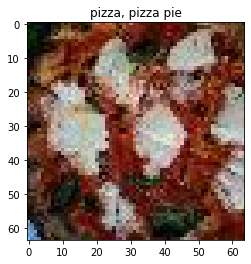

<Figure size 432x288 with 0 Axes>

In [6]:
label_map = pd.read_csv("./tiny-imagenet-200/words.txt", delimiter='\t', header=None)
label_map = dict(zip(label_map[0], label_map[1]))
idx_to_class = {v:k for (k,v) in class_to_idx.items()}
for index, (data, labels) in enumerate(train_dataset):
    break
for image_index in range(len(data)):
    image = data[image_index].detach().numpy().T
    label = labels.detach().numpy()[image_index]
    plt.imshow(image)
    plt.title(f"{label_map[idx_to_class[label]]}")
    plt.figure()
plt.show()

## Linear Model in PyTorch

In [7]:
# Load data into 'flattened' NumPy arrays
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=20)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (640, 12288)
Training Labels Shape: (640,)
Validation Data Shape: (10000, 12288)
Validation Labels Shape: (10000,)


In [8]:
class LinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=num_classes)
        self.activation = torch.nn.LogSigmoid()
    
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation(X)
        return X

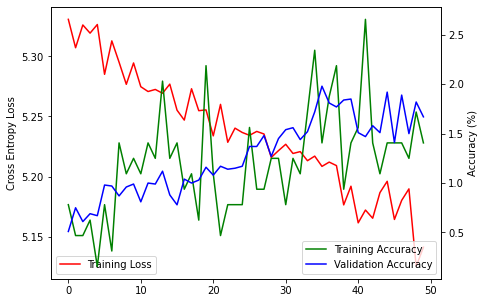

In [9]:
batch_limit = 20

# Load data into 'flattened' NumPy arrays
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=batch_limit)

batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 50
model = LinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 

## Linear Model In PyTorch - 10x Training Data

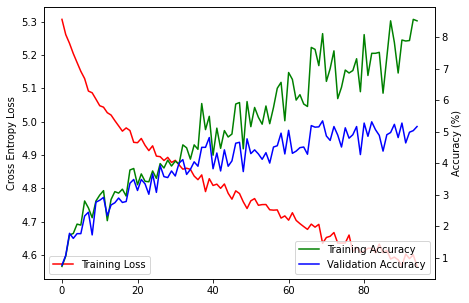

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Mauli/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-ad2c491dd1c7>", line 20, in <module>
    for index, (data, label) in enumerate(train_dataset):
  File "/Users/Mauli/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 435, in __next__
    data = self._next_data()
  File "/Users/Mauli/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 475, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/Users/Mauli/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/Mauli/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[id

TypeError: object of type 'NoneType' has no len()

In [10]:
batch_limit = 200 #num samples

# Load data into 'flattened' NumPy arrays
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=batch_limit)

batch_size = 32 #images per sample
num_features = 64*64*3
num_classes = 200
max_iter = 100
model = LinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 

## Nonlinear Neural Network With One Hidden Layer

In [ ]:
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=200)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

In [ ]:
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=400)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=400, out_features=num_classes)
        self.activation2 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X

In [ ]:
batch_limit = 200
batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 100
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 


## Convolutional Neural Network in PyTorch

In [ ]:
class ConvNet(torch.nn.Module):
     
    def __init__(self, h, w, outputs):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = torch.nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


In [ ]:
batch_limit = 200
num_features = train_data_np[0].shape  # (64, 64, 3)
num_classes = 200
max_iter = 100
model = ConvNet(64, 64, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, 3, 64, 64)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, 3, 64, 64)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 


## Assignment

Think about a modification to one of the above models you would like to make. You could decide to change the data preparation or splitting, the model architecture, loss function, learning algorithm, or any associated paramter. Implement an experiment that enables you to evaluate the impact of your modification. Make sure that your experiment is only studying the effects of one change. For example, you could compare the learning progress of a neural network model with one hidden layer vs. two hidden layers. In this case, you should make sure to use exactly the same training and validation datasets, the same loss function, and the same learning algorithm.

For each experimental condition, you can use the provided code to generate a learning progress plot, but feel free to explore other tools for evaluation, such as a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py). This would be especially helpful to understand in what way your model is making classification errors.

**For submission**, *describe both the model you are starting (control) with* and the *modification you are evaluating (experimental).* What effect do you think your modification will have on training? On overall model performance? Next give a short description of what data you will use in your experiments (e.g. how many images, their format, and how many classes). Then, give a summary of results, clearly indicating the experimental condition to which they belong (i.e. control or experimental).

Comment on your results. Did your modification improve your image classifier? What evidence do you have to support this? Based on your observations or any other sources, what additional changes do you think could further improve your model? Do you think the training data you used contained sufficient training examples for your model to generalize well? Justify your claim.

Format your sumbission as a single Jupyter Notebook or PDF file. Use OWL to submit your assignment. Keep your submission brief: a single page (or equivalent) submission should be adequate.

### Notes

* Depending on your computer's hardware, you may need to scale back your experiments. You can try reducing the number of training iterations, the size of your training set, or the size of your model architecture. Just focus on creating a controlled experiment. 
* Along these lines, don't run experiments that will take too long to run. Test your experiments on a small number of training iterations (5 or so) to get a sense of how long each iteration takes. Even with relatively small training sets, it could take a few hours for model training to finish.

# Your Response

## What model are you starting with?

I'm starting with the NonLinearModel with one hidden layer. The first layer takes in 12288 features and ouputs 400 to the hidden layer. This hidden layer takes those 400 features from the first layer and ouputs 200. 

## What modification are you making?

I'm adding a second hidden layer to this model in my modified class NonLinearModel2. The second hidden layer, which took in 800 features and outputted the same number of features as the number of classes (200), was added after the first layer, which took in 400 features outputted 800 features. I ran both models over 150 iterations. I chose to add a layer because I wanted the step size to be smaller for a potentially more accurate model.

## What data will you use?

My data has been split using the load_data_np function. My batch limit is 200 and my batch size is 32. The number of classes is 200. The shape of my data is as follows:

Training Data Shape: (6400, 12288)

Training Labels Shape: (6400,)

Validation Data Shape: (10000, 12288)

Validation Labels Shape: (10000,)


## Summary of results and your conclusions

Based on the validation accuracy of the two models, the modification of adding a second hidden layer has not improved the model. Both the control and experimental model results can be seen here:

CONTROL:
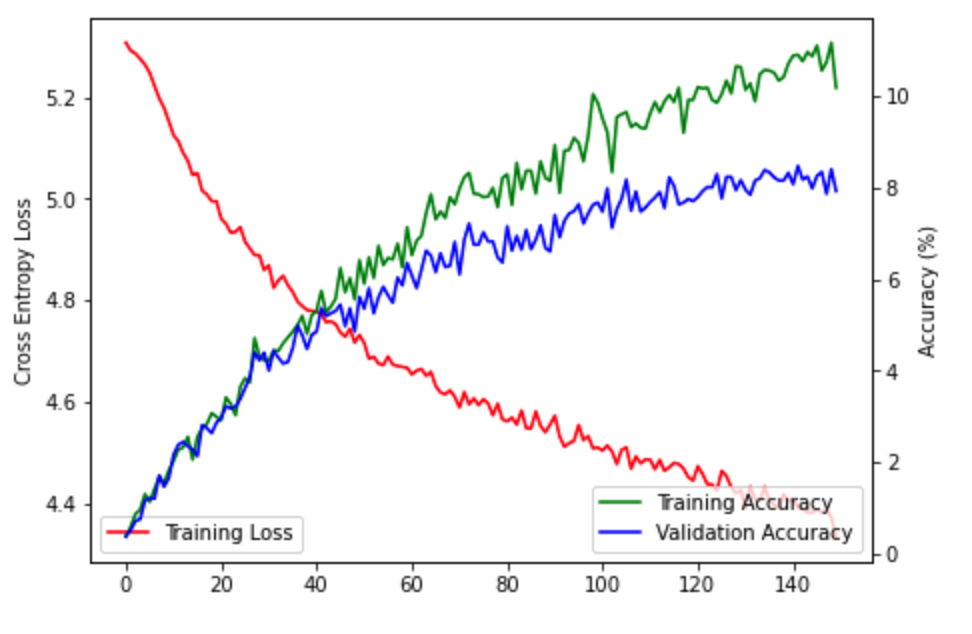


EXPERIMENTAL:
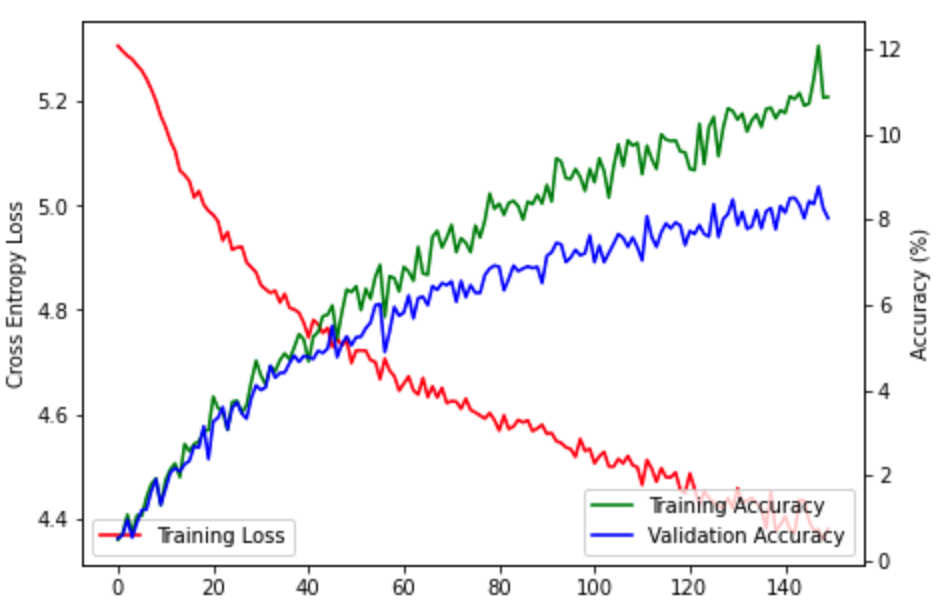


The validation accuracy of NonLinearModel was around 8%, and the validation accuracy of NonLinearModel2 was around 8.2%. Though the model seems to have improved by 0.2%, this is not a significant enough difference as this improvement could be attributed to the "noise" in the validation accuracy. 

The training accuracy of the control model was around 10.5% and the training accuracy of the experimental model approached 12%. This slight improvement in training accuracy in the experimental model despite no significant improvement in validation accuracy shows that the experimental model may have overfit during training. The overfitting can be explained by the increased depth of the neural network: the experimental model has more weights it needs to learn so perhaps the vanishing gradient effect has begun on the model when another hidden layer is added. This can stop neural networks from further learning (as seen by the similar validation accuracies in both control and experimental model). Since we compute gradients via the chain rule, the impact on the front layer is bigger and decreases exponentially with each added layer.

The training loss of both models are approximately the same, with the experimental model having a fraction of a percent more training loss. This similarity is to be expected, because the model starts out poor (high training loss) and improves over the 150 iterations. 

I also noticed a slight difference in slope between the training accuracy of both experimental and control models. The slope of the training accuracy is steeper than that of the control, and this is likely due to increased potential of overfitting. Both layers use a high number of features in both layers, but they are generalized to 200 output classifications. Using more features in a non-linear model's layers may make it the inter-layer classifications more specific but may make it hard to generalize to a smaller number of output classifications. Over more iterations this difference will become more pronounced.

The training data used had fewer images than the validation data, so there is a possibility that adding more images to the training data set could have improved the model, but the improvement would likely apply to both models. However, the batch limit was 200, which led to 10 times more training data than some models seen above in the sample code.

To improve my model and increase its learning potential, I would use a CNN to diminish the effect of the vanishing gradient.

# Your code below

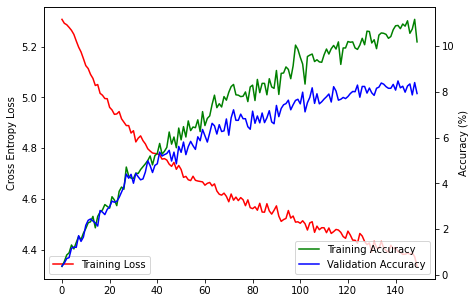

In [11]:
train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=200)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Data Shape: {valid_data_np.shape}")
print(f"Validation Labels Shape: {valid_labels.shape}")

class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=400)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=400, out_features=num_classes)
        self.activation2 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X
    
    
batch_limit = 200
batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 150 # change this!!!
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 
    

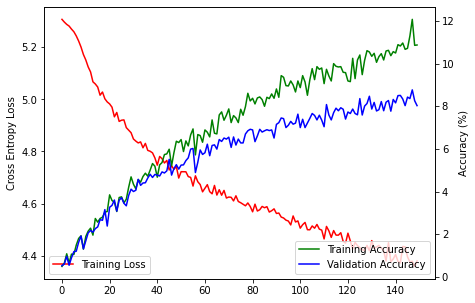

In [12]:


class NonLinearModel2(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=400)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=400, out_features=800)
        self.activation2 = torch.nn.LogSigmoid()
        self.dense3 = torch.nn.Linear(in_features=800, out_features=num_classes)
        self.activation3 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.dense3(X)
        X = self.activation3(X)
        return X

    
batch_limit = 200
batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 150 # change this!!!
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 
    

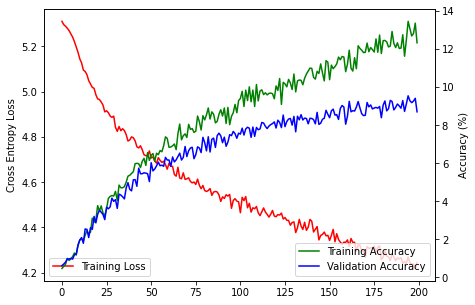

In [16]:
# with 200 iterations
class NonLinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=400)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=400, out_features=num_classes)
        self.activation2 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X
    
    
batch_limit = 200
batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 200 # change this!!!
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 
    

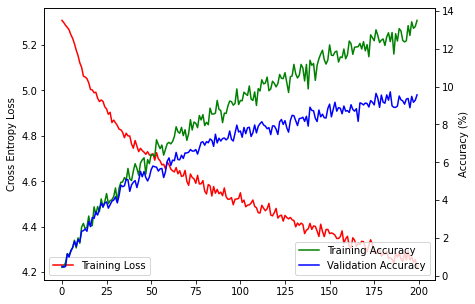

In [15]:
# With 200 iterations
class NonLinearModel2(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=400)
        self.activation1 = torch.nn.LogSigmoid()
        self.dense2 = torch.nn.Linear(in_features=400, out_features=800)
        self.activation2 = torch.nn.LogSigmoid()
        self.dense3 = torch.nn.Linear(in_features=800, out_features=num_classes)
        self.activation3 = torch.nn.LogSigmoid()
        
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.dense3(X)
        X = self.activation3(X)
        return X

    
batch_limit = 200
batch_size = 32
num_features = 64*64*3
num_classes = 200
max_iter = 200 # change this!!!
model = NonLinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
        y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
        y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
        valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        # print(f"Loss at epoch {i}: {loss.item():.4f}\tAccuracy: {accuracy_list[-1]*100:.2f}%", end='\r')
        live_plot(np.array(loss_list), np.array(accuracy_list), valid_list) 